In [1]:
from collections import deque

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from alphazero import PolicyValueNet
from alphazero.train import PolicyValueLoss


In [2]:
class GameDataset(Dataset):
    """ 自我博弈数据集类，每个样本为元组 `(feature_planes, pi, z)` """

    def __init__(self, data_list):
        super().__init__()
        self.__data_deque = deque(data_list)

    def __len__(self):
        return len(self.__data_deque)

    def __getitem__(self, index):
        return self.__data_deque[index]

    def clear(self):
        """ 清空数据集 """
        self.__data_deque.clear()


In [3]:
device = torch.device('cuda:0')

# 创建数网络
policy_value_net = PolicyValueNet(board_len=7, n_feature_planes=13, policy_output_dim=100, is_use_gpu=True)

# 创建优化器和损失函数
optimizer = Adam(policy_value_net.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = PolicyValueLoss()

# self.lr_scheduler = MultiStepLR(self.optimizer, [1500, 2500], gamma=0.1)
# lr_scheduler = ExponentialLR(optimizer, gamma=0.998)  # 0.998 ** 1000 = 0.135



In [4]:
data_list_ = torch.load("./data/maxmax_data_600k.pth")
data_list = []
for data in tqdm(data_list_, ncols=80, desc="Loading data to GPU"):
    f, p, zi = data
    f, p, zi = f.to(device), p.to(device).float(), zi.to(device).float()
    data_list.append((f, p, zi))

data_list_ = None


Loading data to GPU: 100%|███████████| 609070/609070 [00:56<00:00, 10742.94it/s]


In [5]:
dataset = GameDataset(data_list)
print(len(dataset))


609070


In [6]:
data_loader = DataLoader(dataset, batch_size=1000)

In [ ]:
policy_value_net.train()
loss_history = []

epoch_num = 500
save_freq = 100

for epoch in range(epoch_num):
    p_bar = tqdm(enumerate(data_loader, 0), ncols=80, total=len(data_loader), desc=f"Epoch {epoch + 1}")
    for i, data in p_bar:
        feature_planes, pi, z = data

        # 前馈
        p_hat, value = policy_value_net(feature_planes)
        # 梯度清零
        optimizer.zero_grad()
        # 计算损失
        # loss = criterion(p_hat.float(), pi.float(), value.flatten().float(), z.float())
        loss = criterion(p_hat, pi, value.flatten(), z)
        # 误差反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 学习率退火
        # lr_scheduler.step()

    print(f"Epoch {epoch + 1} Loss: {loss.item():.4f}")
    loss_history.append(loss.item())
    if (epoch + 1) % save_freq == 0:
        torch.save(policy_value_net, f"./model/policy_value_net_{epoch + 1}.pth")
        print(f"Save model to ./model/policy_value_net_{epoch + 1}.pth")


Epoch 1: 100%|████████████████████████████████| 610/610 [00:13<00:00, 46.49it/s]


Epoch 1 Loss: 3.4869


Epoch 2: 100%|████████████████████████████████| 610/610 [00:12<00:00, 47.25it/s]


Epoch 2 Loss: 2.8872


Epoch 3: 100%|████████████████████████████████| 610/610 [00:12<00:00, 47.21it/s]


Epoch 3 Loss: 2.4256


Epoch 4: 100%|████████████████████████████████| 610/610 [00:13<00:00, 44.57it/s]


Epoch 4 Loss: 2.1729


Epoch 5: 100%|████████████████████████████████| 610/610 [00:12<00:00, 47.07it/s]


Epoch 5 Loss: 1.9728


Epoch 6: 100%|████████████████████████████████| 610/610 [00:13<00:00, 45.58it/s]


Epoch 6 Loss: 1.7906


Epoch 7: 100%|████████████████████████████████| 610/610 [00:13<00:00, 45.75it/s]


Epoch 7 Loss: 1.6322


Epoch 8: 100%|████████████████████████████████| 610/610 [00:12<00:00, 47.54it/s]


Epoch 8 Loss: 1.5832


Epoch 9: 100%|████████████████████████████████| 610/610 [00:12<00:00, 49.51it/s]


Epoch 9 Loss: 1.4969


Epoch 10: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.43it/s]


Epoch 10 Loss: 1.4251


Epoch 11: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.64it/s]


Epoch 11 Loss: 1.3385


Epoch 12: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.29it/s]


Epoch 12 Loss: 1.2983


Epoch 13: 100%|███████████████████████████████| 610/610 [00:12<00:00, 48.07it/s]


Epoch 13 Loss: 1.2613


Epoch 14: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.37it/s]


Epoch 14 Loss: 1.1861


Epoch 15: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.85it/s]


Epoch 15 Loss: 1.1870


Epoch 16: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.37it/s]


Epoch 16 Loss: 1.1449


Epoch 17: 100%|███████████████████████████████| 610/610 [00:11<00:00, 53.05it/s]


Epoch 17 Loss: 1.1294


Epoch 18: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.77it/s]


Epoch 18 Loss: 1.1438


Epoch 19: 100%|███████████████████████████████| 610/610 [00:11<00:00, 53.12it/s]


Epoch 19 Loss: 1.0764


Epoch 20: 100%|███████████████████████████████| 610/610 [00:11<00:00, 54.31it/s]


Epoch 20 Loss: 1.0955


Epoch 21: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.93it/s]


Epoch 21 Loss: 1.0786


Epoch 22: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.26it/s]


Epoch 22 Loss: 1.0567


Epoch 23: 100%|███████████████████████████████| 610/610 [00:12<00:00, 48.42it/s]


Epoch 23 Loss: 1.0672


Epoch 24: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.07it/s]


Epoch 24 Loss: 1.0159


Epoch 25: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.27it/s]


Epoch 25 Loss: 1.0091


Epoch 26: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.15it/s]


Epoch 26 Loss: 1.0078


Epoch 27: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.97it/s]


Epoch 27 Loss: 1.0061


Epoch 28: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.89it/s]


Epoch 28 Loss: 0.9770


Epoch 29: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.86it/s]


Epoch 29 Loss: 0.9784


Epoch 30: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.88it/s]


Epoch 30 Loss: 0.9715


Epoch 31: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.66it/s]


Epoch 31 Loss: 0.9272


Epoch 32: 100%|███████████████████████████████| 610/610 [00:12<00:00, 48.62it/s]


Epoch 32 Loss: 0.9237


Epoch 33: 100%|███████████████████████████████| 610/610 [00:13<00:00, 45.21it/s]


Epoch 33 Loss: 0.9266


Epoch 34: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.28it/s]


Epoch 34 Loss: 0.9173


Epoch 35: 100%|███████████████████████████████| 610/610 [00:13<00:00, 45.64it/s]


Epoch 35 Loss: 0.8979


Epoch 36: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.39it/s]


Epoch 36 Loss: 0.9037


Epoch 37: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.79it/s]


Epoch 37 Loss: 0.8583


Epoch 38: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.76it/s]


Epoch 38 Loss: 0.8895


Epoch 39: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.87it/s]


Epoch 39 Loss: 0.8839


Epoch 40: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.58it/s]


Epoch 40 Loss: 0.8832


Epoch 41: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.84it/s]


Epoch 41 Loss: 0.8580


Epoch 42: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.64it/s]


Epoch 42 Loss: 0.8420


Epoch 43: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.54it/s]


Epoch 43 Loss: 0.8329


Epoch 44: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.96it/s]


Epoch 44 Loss: 0.8290


Epoch 45: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.30it/s]


Epoch 45 Loss: 0.8705


Epoch 46: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.39it/s]


Epoch 46 Loss: 0.8512


Epoch 47: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.27it/s]


Epoch 47 Loss: 0.8563


Epoch 48: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.59it/s]


Epoch 48 Loss: 0.8500


Epoch 49: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.36it/s]


Epoch 49 Loss: 0.8401


Epoch 50: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.03it/s]


Epoch 50 Loss: 0.8375


Epoch 51: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.98it/s]


Epoch 51 Loss: 0.8157


Epoch 52: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.98it/s]


Epoch 52 Loss: 0.8245


Epoch 53: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.98it/s]


Epoch 53 Loss: 0.7953


Epoch 54: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.33it/s]


Epoch 54 Loss: 0.8159


Epoch 55: 100%|███████████████████████████████| 610/610 [00:11<00:00, 50.97it/s]


Epoch 55 Loss: 0.8283


Epoch 56: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.66it/s]


Epoch 56 Loss: 0.8261


Epoch 57: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.86it/s]


Epoch 57 Loss: 0.8053


Epoch 58: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.97it/s]


Epoch 58 Loss: 0.7995


Epoch 59: 100%|███████████████████████████████| 610/610 [00:11<00:00, 52.09it/s]


Epoch 59 Loss: 0.7564


Epoch 60: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.98it/s]


Epoch 60 Loss: 0.7817


Epoch 61: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.27it/s]


Epoch 61 Loss: 0.7546


Epoch 62: 100%|███████████████████████████████| 610/610 [00:12<00:00, 48.43it/s]


Epoch 62 Loss: 0.7585


Epoch 63: 100%|███████████████████████████████| 610/610 [00:13<00:00, 46.79it/s]


Epoch 63 Loss: 0.7758


Epoch 64: 100%|███████████████████████████████| 610/610 [00:13<00:00, 45.87it/s]


Epoch 64 Loss: 0.7779


Epoch 65: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.20it/s]


Epoch 65 Loss: 0.7576


Epoch 66: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.88it/s]


Epoch 66 Loss: 0.7834


Epoch 67: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.23it/s]


Epoch 67 Loss: 0.7791


Epoch 68: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.83it/s]


Epoch 68 Loss: 0.7487


Epoch 69: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.84it/s]


Epoch 69 Loss: 0.7274


Epoch 70: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.10it/s]


Epoch 70 Loss: 0.7542


Epoch 71: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.64it/s]


Epoch 71 Loss: 0.7485


Epoch 72: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.52it/s]


Epoch 72 Loss: 0.7309


Epoch 73: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.69it/s]


Epoch 73 Loss: 0.7332


Epoch 74: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.72it/s]


Epoch 74 Loss: 0.7273


Epoch 75: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.18it/s]


Epoch 75 Loss: 0.7152


Epoch 76: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.91it/s]


Epoch 76 Loss: 0.7299


Epoch 77: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.49it/s]


Epoch 77 Loss: 0.7057


Epoch 78: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.41it/s]


Epoch 78 Loss: 0.7060


Epoch 79: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.51it/s]


Epoch 79 Loss: 0.7270


Epoch 80: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.32it/s]


Epoch 80 Loss: 0.7030


Epoch 81: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.20it/s]


Epoch 81 Loss: 0.6992


Epoch 82: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.63it/s]


Epoch 82 Loss: 0.7266


Epoch 83: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.39it/s]


Epoch 83 Loss: 0.6937


Epoch 84: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.76it/s]


Epoch 84 Loss: 0.7058


Epoch 85: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.26it/s]


Epoch 85 Loss: 0.7155


Epoch 86: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.43it/s]


Epoch 86 Loss: 0.7055


Epoch 87: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.31it/s]


Epoch 87 Loss: 0.7063


Epoch 88: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.52it/s]


Epoch 88 Loss: 0.7130


Epoch 89: 100%|███████████████████████████████| 610/610 [00:12<00:00, 50.12it/s]


Epoch 89 Loss: 0.7231


Epoch 90: 100%|███████████████████████████████| 610/610 [00:11<00:00, 51.22it/s]


Epoch 90 Loss: 0.7532


Epoch 91: 100%|███████████████████████████████| 610/610 [00:12<00:00, 49.46it/s]


Epoch 91 Loss: 0.7462


Epoch 92: 100%|███████████████████████████████| 610/610 [00:13<00:00, 46.32it/s]


Epoch 92 Loss: 0.7156


Epoch 93: 100%|███████████████████████████████| 610/610 [35:46<00:00,  3.52s/it]


Epoch 93 Loss: 0.7331


Epoch 94: 100%|███████████████████████████████| 610/610 [00:12<00:00, 47.51it/s]


Epoch 94 Loss: 0.7223


Epoch 95: 100%|███████████████████████████████| 610/610 [00:10<00:00, 56.99it/s]


Epoch 95 Loss: 0.7194


Epoch 96:  26%|████████                       | 159/610 [00:02<00:07, 59.15it/s]

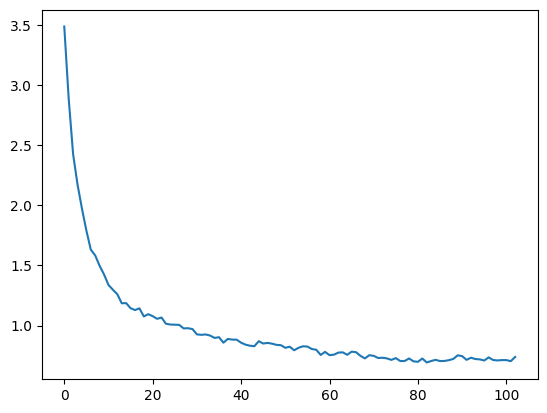

In [8]:
from matplotlib import pyplot as plt

plt.plot(loss_history)
plt.show()